In [ ]:
# Standard import(s)
import numpy as np
import csv
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Keras import(s)
#if float(tf.__version__[:3])>2.8:
from tensorflow.keras.utils import plot_model
#from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import BatchNormalization,Input, Dense, Dropout, Flatten, Reshape, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Lambda, UpSampling2D
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.losses import mae
from tensorflow.keras.losses import mean_squared_error 
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

# Keras import(s)
if float(tf.__version__[:3])>2.8:
    from tensorflow.keras.utils import plot_model
else:
    from tensorflow.keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
fname = 'mc-chic1.csv'
df =pd.read_csv(fname)                    #read csv file into df
df = df.drop(df.columns[0], axis=1)       #drop first column containing column numbers
print(df.isna().sum() )                   #print number of null values in each column

#There are no null values to remove


NameError: name 'pd' is not defined

In [21]:
print(df)

              ep       eta           p       phi  pol        pt          qp  \
0       0.005459  3.210803   72.079880  0.294754  1.0  5.803692   72.079880   
1       0.004050  4.436362   37.638340 -0.088796  1.0  0.891071  -37.638340   
2       0.003901  3.577396   18.565832  0.319936  1.0  1.036960   18.565832   
3       0.003859  3.532860    8.632520  0.219504  1.0  0.504075   -8.632520   
4       0.004975  3.300828   43.359665 -0.720869  1.0  3.191501   43.359665   
...          ...       ...         ...       ...  ...       ...         ...   
208979  0.007196  4.140301    7.805385  0.284841 -1.0  0.248430   -7.805385   
208980  0.007210  3.852298  160.216980  2.341455 -1.0  6.800037  160.216980   
208981  0.004592  4.234431   32.691210  1.112678 -1.0  0.947065  -32.691210   
208982  0.003816  4.122482   14.349394  2.564155 -1.0  0.464920   14.349394   
208983  0.004138  4.130126   12.054873  2.654359 -1.0  0.387605  -12.054873   

              tx        ty       zV  
0       0.077

Text(0.5, 0, 'p')

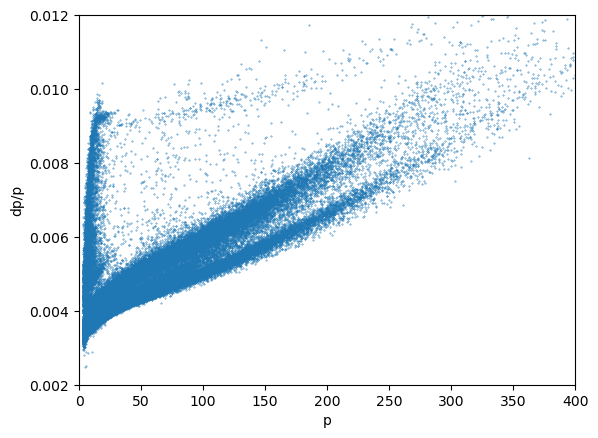

In [29]:
fig,ax = plt.subplots()
plt.scatter(df['p'],df['ep'],s=0.1)

ax.set_xlim(0,400)
ax.set_ylim(0.002,0.012)
plt.ylabel('dp/p')
plt.xlabel('p')

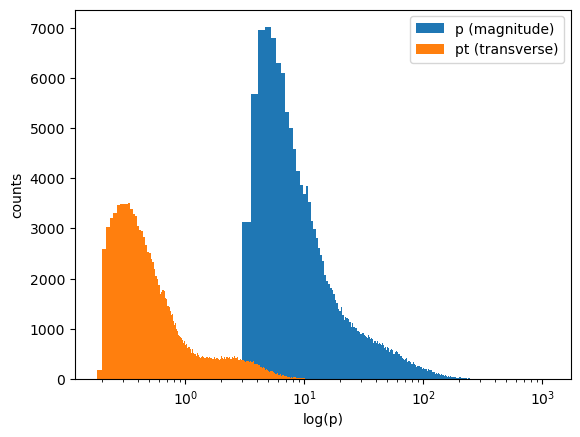

In [196]:
#nbins = np.logspace(start=np.log10(10), stop=np.log10(15), num=100)
nbins = 2000
plt.hist(df['p'], bins=nbins,label = 'p (magnitude)')
plt.hist(df['pt'], bins=nbins, label = 'pt (transverse)')
plt.gca().set_xscale("log")
plt.xlabel('log(p)')
plt.ylabel('counts')
plt.legend()
plt.show()

In [49]:
df2 = df.copy() #make copy of dataframe
pz = np.sqrt(df['p']**2 - df['pt']**2)
epz = df['ep']*df['p']/pz                  #calculate resolution
df['pz'] = pz
df['epz'] = epz


Text(0.5, 0, 'pz')

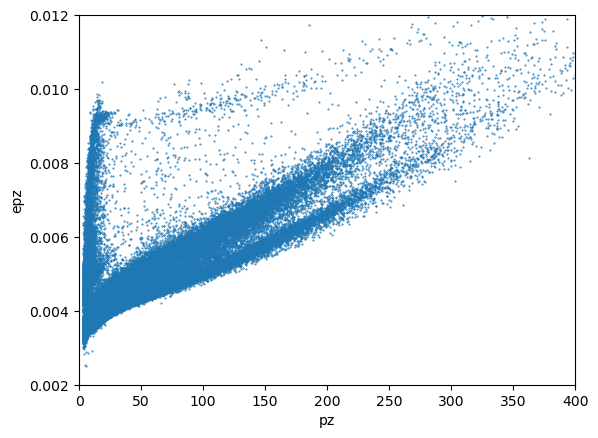

In [69]:
fig,ax = plt.subplots()
plt.scatter(df['pz'],df['epz'],s=0.2)
ax.set_xlim(0,400)
ax.set_ylim(0.002,0.012)
plt.ylabel('epz')
plt.xlabel('pz')

This is qualitatively identical to figure 1 because we can see three distinct bands. The first band (left-most) peaks at approximately 0.01 dp/p in both graphs and is an almost vertical band. The other two bands have significantly lower gradients and become distinctly separate from each other at approximately p =120 Gev/c. Each band in both the graphs seem to follow a linear pattern.

In the 1d distributions we can clearly see that pt < p. In this second plot we have shown that a plot of epz against pz is practically identical to dp/p against p which suggests that most of the momentum is in the z-direction, ie p is approximately equal to p_z. Therefore, from the two plots we have shown that p_t << p_z.

In [60]:
# num of inputs = 5 (p, tx , ty , eta , phi ), num of outputs = 1 (ep)
num_inputs = 5; num_outputs = 1
# simple Keras model : use same # of nodes as # of inputs , single layer
num_nodes = num_inputs
def simple_model():
    # create model
    model = Sequential()
    # no activation required for the output , as this is a regression problem ,
    # ie. we need a numerical prediction for any input
    model.add(Dense(num_nodes, input_dim = num_inputs , kernel_initializer ='normal',activation ='relu'))
    model.add(Dropout(0.2))     #reduce overtraining with dropouts
    model.add(Dense(num_outputs , kernel_initializer ='normal'))
    # Compile model
    model.compile(loss ='mean_squared_error', optimizer ='adam')
    return model




In [99]:
N_epochs = 10
batchsize = 1000
Answer_to_all_questions = 42   #set random seed

data = df[['p','tx','ty','eta','phi']].copy()  #create dataframe for data
target = df['ep'].copy()                       #create dataframe for target 


In [109]:
np.random.seed(Answer_to_all_questions)
estimator = KerasRegressor(build_fn = simple_model,epochs = N_epochs ,batch_size = batchsize,verbose=1 ) #create estimator
kfold = KFold(n_splits =10,random_state = Answer_to_all_questions ,shuffle = True )
# data and target are 5-column and 1-column arrays produced with pandas.DataFrame.values
results = cross_val_score(estimator,data ,target ,cv =kfold ,scoring ='r2')


C:\Users\Theo\AppData\Local\Temp\ipykernel_4292\2596104251.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn = simple_model,epochs = N_epochs ,batch_size = batchsize,verbose=1 )


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 3s 15us/sample - loss: 0.0013
Epoch 2/10
188085/188085 [==============================] - 1s 4us/sample - loss: 4.0445e-06
Epoch 3/10
188085/188085 [==============================] - 1s 4us/sample - loss: 9.9616e-07
Epoch 4/10
188085/188085 [==============================] - 1s 5us/sample - loss: 6.1861e-07
Epoch 5/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.6557e-07
Epoch 6/10
188085/188085 [==============================] - 1s 5us/sample - loss: 5.4536e-07
Epoch 7/10
188085/188085 [==============================] - 1s 5us/sample - loss: 5.4268e-07
Epoch 8/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.3584e-07
Epoch 9/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.3855e-07
Epoch 10/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.4438e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 3s 16us/sample - loss: 0.0016
Epoch 2/10
188085/188085 [==============================] - 1s 4us/sample - loss: 1.8857e-05
Epoch 3/10
188085/188085 [==============================] - 1s 4us/sample - loss: 1.4347e-06
Epoch 4/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.6251e-07
Epoch 5/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.2892e-07
Epoch 6/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.3044e-07
Epoch 7/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.2789e-07
Epoch 8/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.1886e-07
Epoch 9/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.1374e-07
Epoch 10/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.1449e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 3s 15us/sample - loss: 0.0234
Epoch 2/10
188085/188085 [==============================] - 1s 5us/sample - loss: 0.0011
Epoch 3/10
188085/188085 [==============================] - 1s 5us/sample - loss: 2.4469e-04
Epoch 4/10
188085/188085 [==============================] - 1s 4us/sample - loss: 8.5137e-05
Epoch 5/10
188085/188085 [==============================] - 1s 4us/sample - loss: 3.8220e-05
Epoch 6/10
188085/188085 [==============================] - 1s 4us/sample - loss: 1.9446e-05
Epoch 7/10
188085/188085 [==============================] - 1s 4us/sample - loss: 1.0896e-05
Epoch 8/10
188085/188085 [==============================] - 1s 4us/sample - loss: 6.5357e-06
Epoch 9/10
188085/188085 [==============================] - 1s 4us/sample - loss: 4.0608e-06
Epoch 10/10
188085/188085 [==============================] - 1s 4us/sample - loss: 2.6140e-06


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 4s 19us/sample - loss: 2.1097e-06
Epoch 2/10
188085/188085 [==============================] - 1s 4us/sample - loss: 1.0604e-06
Epoch 3/10
188085/188085 [==============================] - 1s 4us/sample - loss: 1.0382e-06
Epoch 4/10
188085/188085 [==============================] - 1s 4us/sample - loss: 9.8973e-07
Epoch 5/10
188085/188085 [==============================] - 1s 4us/sample - loss: 8.7125e-07
Epoch 6/10
188085/188085 [==============================] - 1s 4us/sample - loss: 8.2521e-07
Epoch 7/10
188085/188085 [==============================] - 1s 4us/sample - loss: 8.2084e-07
Epoch 8/10
188085/188085 [==============================] - 1s 4us/sample - loss: 8.1183e-07
Epoch 9/10
188085/188085 [==============================] - 1s 4us/sample - loss: 8.1215e-07
Epoch 10/10
188085/188085 [==============================] - 1s 4us/sample - loss: 8.0511e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 3s 14us/sample - loss: 1.2925e-04
Epoch 2/10
188086/188086 [==============================] - 1s 4us/sample - loss: 6.0936e-07
Epoch 3/10
188086/188086 [==============================] - 1s 4us/sample - loss: 5.8181e-07
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.8428e-07
Epoch 5/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.7996e-07
Epoch 6/10
188086/188086 [==============================] - 1s 4us/sample - loss: 5.7928e-07
Epoch 7/10
188086/188086 [==============================] - 1s 4us/sample - loss: 5.7499e-07
Epoch 8/10
188086/188086 [==============================] - 1s 4us/sample - loss: 5.7236e-07
Epoch 9/10
188086/188086 [==============================] - 1s 4us/sample - loss: 5.7716e-07
Epoch 10/10
188086/188086 [==============================] - 1s 4us/sample - loss: 5.6665e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 3s 17us/sample - loss: 0.0235
Epoch 2/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.8719e-04
Epoch 3/10
188086/188086 [==============================] - 1s 5us/sample - loss: 7.2325e-05
Epoch 4/10
188086/188086 [==============================] - 1s 4us/sample - loss: 1.9091e-05
Epoch 5/10
188086/188086 [==============================] - 1s 4us/sample - loss: 5.6193e-06
Epoch 6/10
188086/188086 [==============================] - 1s 5us/sample - loss: 1.7772e-06
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 7.3086e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.7345e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1781e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.0704e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 3s 15us/sample - loss: 0.0016
Epoch 2/10
188086/188086 [==============================] - 1s 4us/sample - loss: 1.8285e-05
Epoch 3/10
188086/188086 [==============================] - 1s 4us/sample - loss: 2.8061e-06
Epoch 4/10
188086/188086 [==============================] - 1s 4us/sample - loss: 1.0407e-06
Epoch 5/10
188086/188086 [==============================] - 1s 4us/sample - loss: 6.1481e-07
Epoch 6/10
188086/188086 [==============================] - 1s 4us/sample - loss: 5.4300e-07
Epoch 7/10
188086/188086 [==============================] - 1s 4us/sample - loss: 5.3012e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.1933e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.1405e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.0880e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 4s 21us/sample - loss: 0.0500
Epoch 2/10
188086/188086 [==============================] - 1s 5us/sample - loss: 0.0020
Epoch 3/10
188086/188086 [==============================] - 1s 4us/sample - loss: 3.7802e-04
Epoch 4/10
188086/188086 [==============================] - 1s 4us/sample - loss: 1.0239e-04
Epoch 5/10
188086/188086 [==============================] - 1s 4us/sample - loss: 2.9186e-05
Epoch 6/10
188086/188086 [==============================] - 1s 4us/sample - loss: 8.1049e-06
Epoch 7/10
188086/188086 [==============================] - 1s 4us/sample - loss: 2.1869e-06
Epoch 8/10
188086/188086 [==============================] - 1s 4us/sample - loss: 7.6216e-07
Epoch 9/10
188086/188086 [==============================] - 1s 4us/sample - loss: 4.7537e-07
Epoch 10/10
188086/188086 [==============================] - 1s 4us/sample - loss: 4.2864e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 3s 16us/sample - loss: 0.0730
Epoch 2/10
188086/188086 [==============================] - 1s 4us/sample - loss: 0.0026
Epoch 3/10
188086/188086 [==============================] - 1s 4us/sample - loss: 3.2843e-04
Epoch 4/10
188086/188086 [==============================] - 1s 4us/sample - loss: 5.7888e-05
Epoch 5/10
188086/188086 [==============================] - 1s 4us/sample - loss: 1.5507e-05
Epoch 6/10
188086/188086 [==============================] - 1s 4us/sample - loss: 5.7422e-06
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 2.8639e-06
Epoch 8/10
188086/188086 [==============================] - 1s 4us/sample - loss: 1.6736e-06
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 1.1478e-06
Epoch 10/10
188086/188086 [==============================] - 1s 4us/sample - loss: 8.8149e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 3s 15us/sample - loss: 0.0015
Epoch 2/10
188086/188086 [==============================] - 1s 4us/sample - loss: 1.1286e-05
Epoch 3/10
188086/188086 [==============================] - 1s 5us/sample - loss: 1.6487e-06
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 7.8918e-07
Epoch 5/10
188086/188086 [==============================] - 1s 5us/sample - loss: 6.2221e-07
Epoch 6/10
188086/188086 [==============================] - 1s 4us/sample - loss: 5.7287e-07
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.5842e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.5416e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.5760e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.5396e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [206]:
#round R^2 to same number of significnt figures as standard deviation

print(" R^2 = %.1f" % results.mean())
print("std on R^2  = %.1g"%results.std())

 R^2 = 0.6
std on R^2  = 0.1


In [111]:
#create pipelined estimator
estimators = []
estimators.append(('standardize',StandardScaler()))   #scale data
estimators.append(( 'mlp', KerasRegressor(build_fn = simple_model,epochs= N_epochs ,batch_size = batchsize)))
pipeline= Pipeline(estimators)

C:\Users\Theo\AppData\Local\Temp\ipykernel_4292\3640164194.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators.append(( 'mlp', KerasRegressor(build_fn = simple_model,epochs= N_epochs ,batch_size = batchsize)))


In [112]:
# data and target are 5- column and 1- column arrays produced with pandas . DataFrame . values
results_pipelined = cross_val_score(pipeline,data ,target ,cv =kfold ,scoring ='r2')


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 3s 16us/sample - loss: 9.5274e-06
Epoch 2/10
188085/188085 [==============================] - 1s 5us/sample - loss: 6.2983e-07
Epoch 3/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.1849e-07
Epoch 4/10
188085/188085 [==============================] - 1s 4us/sample - loss: 4.6931e-07
Epoch 5/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.4274e-07
Epoch 6/10
188085/188085 [==============================] - 1s 4us/sample - loss: 4.2145e-07
Epoch 7/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.1831e-07
Epoch 8/10
188085/188085 [==============================] - 1s 4us/sample - loss: 4.1304e-07
Epoch 9/10
188085/188085 [==============================] - 1s 4us/sample - loss: 4.0934e-07
Epoch 10/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.0592e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 3s 17us/sample - loss: 1.8353e-05
Epoch 2/10
188085/188085 [==============================] - 1s 4us/sample - loss: 8.8712e-07
Epoch 3/10
188085/188085 [==============================] - 1s 5us/sample - loss: 6.3221e-07
Epoch 4/10
188085/188085 [==============================] - 1s 5us/sample - loss: 6.0173e-07
Epoch 5/10
188085/188085 [==============================] - 1s 5us/sample - loss: 5.8581e-07
Epoch 6/10
188085/188085 [==============================] - 1s 5us/sample - loss: 5.6644e-07
Epoch 7/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.4517e-07
Epoch 8/10
188085/188085 [==============================] - 1s 5us/sample - loss: 5.2711e-07
Epoch 9/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.1192e-07
Epoch 10/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.0749e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 3s 17us/sample - loss: 1.6363e-05
Epoch 2/10
188085/188085 [==============================] - 1s 5us/sample - loss: 8.2163e-07
Epoch 3/10
188085/188085 [==============================] - 1s 5us/sample - loss: 5.6888e-07
Epoch 4/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.2877e-07
Epoch 5/10
188085/188085 [==============================] - 1s 5us/sample - loss: 5.1371e-07
Epoch 6/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.9855e-07
Epoch 7/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.8483e-07
Epoch 8/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.6912e-07
Epoch 9/10
188085/188085 [==============================] - 1s 4us/sample - loss: 4.6325e-07
Epoch 10/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.5272e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 3s 16us/sample - loss: 7.2900e-06
Epoch 2/10
188085/188085 [==============================] - 1s 5us/sample - loss: 6.9988e-07
Epoch 3/10
188085/188085 [==============================] - 1s 4us/sample - loss: 5.8519e-07
Epoch 4/10
188085/188085 [==============================] - 1s 5us/sample - loss: 5.2154e-07
Epoch 5/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.8819e-07
Epoch 6/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.7827e-07
Epoch 7/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.6646e-07
Epoch 8/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.5594e-07
Epoch 9/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.0686e-07
Epoch 10/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.8145e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 3s 16us/sample - loss: 1.0955e-05
Epoch 2/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.9564e-07
Epoch 3/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.4513e-07
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.2605e-07
Epoch 5/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1579e-07
Epoch 6/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1331e-07
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.0873e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1231e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1006e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1007e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 3s 17us/sample - loss: 6.9991e-06
Epoch 2/10
188086/188086 [==============================] - 1s 5us/sample - loss: 6.4136e-07
Epoch 3/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.3188e-07
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.0167e-07
Epoch 5/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.9331e-07
Epoch 6/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.8373e-07
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.7757e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.6970e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.7254e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.5050e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 4s 20us/sample - loss: 1.0474e-05
Epoch 2/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.3720e-07
Epoch 3/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.0719e-07
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.8649e-07
Epoch 5/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.6676e-07
Epoch 6/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.5739e-07
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.2847e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1511e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1247e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.0664e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 4s 22us/sample - loss: 2.8687e-06
Epoch 2/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.0198e-07
Epoch 3/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.6772e-07
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.4112e-07
Epoch 5/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.3149e-07
Epoch 6/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.2657e-07
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1988e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1262e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.0763e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.0520e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 4s 19us/sample - loss: 8.4051e-06
Epoch 2/10
188086/188086 [==============================] - 1s 5us/sample - loss: 6.3471e-07
Epoch 3/10
188086/188086 [==============================] - 1s 5us/sample - loss: 5.2420e-07
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.9132e-07
Epoch 5/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.6783e-07
Epoch 6/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.5498e-07
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.4297e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.3397e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.2194e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.2652e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 3s 18us/sample - loss: 2.4488e-06
Epoch 2/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.3337e-07
Epoch 3/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.2167e-07
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1356e-07
Epoch 5/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.0429e-07
Epoch 6/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.9658e-07
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.9946e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.9195e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.9300e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.8869e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [208]:
print(" R^2 = %.2f" % results_pipelined.mean())
print("std on R^2  = %.1g"%results_pipelined.std())

 R^2 = 0.70
std on R^2  = 0.02


Use standardised inputs since this model had lower loss and lower standard deviation and a higher R squared.

In [114]:
def denser_model():
    # create model
    model = Sequential()
    # no activation required for the output , as this is a regression problem ,
    # ie. we need a numerical prediction for any input
    model.add(Dense(num_nodes, input_dim = num_inputs , kernel_initializer ='normal',activation ='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4 , kernel_initializer ='normal'))              #number of input nodes = 5
    model.add(Dense(num_outputs , kernel_initializer ='normal'))
    # Compile model
    model.compile(loss ='mean_squared_error', optimizer ='adam')
    return model

In [115]:
#create pipelined estimator for denser model
estimators2 = []
estimators2.append(('standardize',StandardScaler()))
estimators2.append(( 'mlp', KerasRegressor(build_fn = denser_model,epochs= N_epochs ,batch_size = batchsize)))
pipeline2= Pipeline(estimators2)

C:\Users\Theo\AppData\Local\Temp\ipykernel_4292\1919133605.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators2.append(( 'mlp', KerasRegressor(build_fn = denser_model,epochs= N_epochs ,batch_size = batchsize)))


In [116]:

# data and target are 5- column and 1- column arrays produced with pandas . DataFrame . values
results_denser = cross_val_score(pipeline2,data ,target ,cv =kfold ,scoring ='r2')


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 3s 18us/sample - loss: 1.1272e-06
Epoch 2/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.1562e-07
Epoch 3/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.7792e-07
Epoch 4/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.7066e-07
Epoch 5/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6819e-07
Epoch 6/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6641e-07
Epoch 7/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6165e-07
Epoch 8/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.5904e-07
Epoch 9/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6391e-07
Epoch 10/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6192e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 3s 18us/sample - loss: 1.0008e-06
Epoch 2/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.3275e-07
Epoch 3/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.1296e-07
Epoch 4/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.9237e-07
Epoch 5/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.8486e-07
Epoch 6/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.8128e-07
Epoch 7/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.8118e-07
Epoch 8/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.8198e-07
Epoch 9/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.7904e-07
Epoch 10/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.7736e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 3s 18us/sample - loss: 9.2632e-07
Epoch 2/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.3587e-07
Epoch 3/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.8978e-07
Epoch 4/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6912e-07
Epoch 5/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6293e-07
Epoch 6/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6331e-07
Epoch 7/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6058e-07
Epoch 8/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6113e-07
Epoch 9/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.5969e-07
Epoch 10/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.5665e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 4s 19us/sample - loss: 9.4484e-07
Epoch 2/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.4101e-07
Epoch 3/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.2982e-07
Epoch 4/10
188085/188085 [==============================] - 1s 5us/sample - loss: 4.1870e-07
Epoch 5/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.9247e-07
Epoch 6/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.7466e-07
Epoch 7/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6527e-07
Epoch 8/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6627e-07
Epoch 9/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6544e-07
Epoch 10/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.6030e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 4s 21us/sample - loss: 1.1032e-06
Epoch 2/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.5707e-07
Epoch 3/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.3265e-07
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.2048e-07
Epoch 5/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1766e-07
Epoch 6/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1613e-07
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1202e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1023e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.0602e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1013e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 4s 24us/sample - loss: 8.7281e-07
Epoch 2/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.4809e-07
Epoch 3/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.9220e-07
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7556e-07
Epoch 5/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.7217e-07
Epoch 6/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.7429e-07
Epoch 7/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.7445e-07
Epoch 8/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.7283e-07
Epoch 9/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.7270e-07
Epoch 10/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.7089e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 5s 27us/sample - loss: 1.7189e-06
Epoch 2/10
188086/188086 [==============================] - 1s 6us/sample - loss: 5.7523e-07
Epoch 3/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.4649e-07
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.2520e-07
Epoch 5/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.2408e-07
Epoch 6/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1585e-07
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1434e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1259e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1012e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.1175e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 5s 25us/sample - loss: 1.0108e-06
Epoch 2/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.9713e-07
Epoch 3/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.8208e-07
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7619e-07
Epoch 5/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7246e-07
Epoch 6/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7350e-07
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7001e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7272e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7300e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7166e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 5s 24us/sample - loss: 9.7266e-07
Epoch 2/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.4804e-07
Epoch 3/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.0351e-07
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.8979e-07
Epoch 5/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.8038e-07
Epoch 6/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.6901e-07
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.6117e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.6094e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.6372e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.6007e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 5s 25us/sample - loss: 1.0244e-06
Epoch 2/10
188086/188086 [==============================] - 1s 5us/sample - loss: 4.0123e-07
Epoch 3/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.8131e-07
Epoch 4/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7663e-07
Epoch 5/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7136e-07
Epoch 6/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7197e-07
Epoch 7/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7172e-07
Epoch 8/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7305e-07
Epoch 9/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7321e-07
Epoch 10/10
188086/188086 [==============================] - 1s 5us/sample - loss: 3.7353e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [210]:
print(" R^2 = %.3f" % results_denser.mean())
print("std on R^2  = %.1g"%results_denser.std())

 R^2 = 0.722
std on R^2  = 0.009


In [118]:
#create wider model
def wider_model():
    # create model
    model = Sequential()
    # no activation required for the output , as this is a regression problem ,
    # ie. we need a numerical prediction for any input
    #double input layer size
    model.add(Dense(2*num_nodes, input_dim = num_inputs , kernel_initializer ='normal',activation ='relu')) 
    model.add(Dropout(0.2))
    model.add(Dense(num_outputs , kernel_initializer ='normal'))
    # Compile model
    model.compile(loss ='mean_squared_error', optimizer ='adam')
    return model

In [119]:
#create pipelined estimator for wider model
estimators3 = []
estimators3.append(('standardize',StandardScaler()))
estimators3.append(( 'mlp', KerasRegressor(build_fn = wider_model,epochs= N_epochs ,batch_size = batchsize)))
pipeline3= Pipeline(estimators3)

C:\Users\Theo\AppData\Local\Temp\ipykernel_4292\2185812323.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators3.append(( 'mlp', KerasRegressor(build_fn = wider_model,epochs= N_epochs ,batch_size = batchsize)))


In [120]:
results_wider = cross_val_score(pipeline3,data ,target ,cv =kfold ,scoring ='r2')


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 5s 25us/sample - loss: 7.8498e-06
Epoch 2/10
188085/188085 [==============================] - 1s 6us/sample - loss: 5.9203e-07
Epoch 3/10
188085/188085 [==============================] - 1s 6us/sample - loss: 4.7468e-07
Epoch 4/10
188085/188085 [==============================] - 1s 5us/sample - loss: 3.8591e-07
Epoch 5/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.7658e-07
Epoch 6/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.7103e-07
Epoch 7/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.7135e-07
Epoch 8/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.6381e-07
Epoch 9/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.6264e-07
Epoch 10/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.5670e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 5s 26us/sample - loss: 1.5875e-05
Epoch 2/10
188085/188085 [==============================] - 1s 6us/sample - loss: 8.2184e-07
Epoch 3/10
188085/188085 [==============================] - 1s 6us/sample - loss: 6.0562e-07
Epoch 4/10
188085/188085 [==============================] - 1s 6us/sample - loss: 5.3140e-07
Epoch 5/10
188085/188085 [==============================] - 1s 6us/sample - loss: 4.5905e-07
Epoch 6/10
188085/188085 [==============================] - 1s 6us/sample - loss: 4.3151e-07
Epoch 7/10
188085/188085 [==============================] - 1s 6us/sample - loss: 4.1754e-07
Epoch 8/10
188085/188085 [==============================] - 1s 6us/sample - loss: 4.0288e-07
Epoch 9/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.9318e-07
Epoch 10/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.8368e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 4s 24us/sample - loss: 2.0021e-05
Epoch 2/10
188085/188085 [==============================] - 1s 6us/sample - loss: 9.2277e-07
Epoch 3/10
188085/188085 [==============================] - 1s 6us/sample - loss: 7.7739e-07
Epoch 4/10
188085/188085 [==============================] - 1s 6us/sample - loss: 6.8515e-07
Epoch 5/10
188085/188085 [==============================] - 1s 6us/sample - loss: 6.5613e-07
Epoch 6/10
188085/188085 [==============================] - 1s 6us/sample - loss: 6.4059e-07
Epoch 7/10
188085/188085 [==============================] - 1s 6us/sample - loss: 6.2508e-07
Epoch 8/10
188085/188085 [==============================] - 1s 6us/sample - loss: 6.0869e-07
Epoch 9/10
188085/188085 [==============================] - 1s 6us/sample - loss: 5.8604e-07
Epoch 10/10
188085/188085 [==============================] - 1s 6us/sample - loss: 5.6409e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/10
188085/188085 [==============================] - 4s 22us/sample - loss: 3.6763e-06
Epoch 2/10
188085/188085 [==============================] - 1s 6us/sample - loss: 4.7611e-07
Epoch 3/10
188085/188085 [==============================] - 1s 6us/sample - loss: 4.3751e-07
Epoch 4/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.9565e-07
Epoch 5/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.7779e-07
Epoch 6/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.6867e-07
Epoch 7/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.5851e-07
Epoch 8/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.5232e-07
Epoch 9/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.4430e-07
Epoch 10/10
188085/188085 [==============================] - 1s 6us/sample - loss: 3.4083e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 4s 21us/sample - loss: 7.4097e-06
Epoch 2/10
188086/188086 [==============================] - 1s 6us/sample - loss: 5.1929e-07
Epoch 3/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.2398e-07
Epoch 4/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.9160e-07
Epoch 5/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.8056e-07
Epoch 6/10
188086/188086 [==============================] - 2s 12us/sample - loss: 3.6570e-07
Epoch 7/10
188086/188086 [==============================] - 5s 29us/sample - loss: 3.6580e-07
Epoch 8/10
188086/188086 [==============================] - 2s 8us/sample - loss: 3.5436e-07
Epoch 9/10
188086/188086 [==============================] - 2s 9us/sample - loss: 3.4733e-07
Epoch 10/10
188086/188086 [==============================] - 2s 8us/sample - loss: 3.4363e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 2513s 13ms/sample - loss: 1.4460e-05
Epoch 2/10
188086/188086 [==============================] - 3s 14us/sample - loss: 6.6536e-07
Epoch 3/10
188086/188086 [==============================] - 2s 8us/sample - loss: 4.7006e-07
Epoch 4/10
188086/188086 [==============================] - 2s 8us/sample - loss: 4.3956e-07
Epoch 5/10
188086/188086 [==============================] - 2s 8us/sample - loss: 4.2306e-07
Epoch 6/10
188086/188086 [==============================] - 1s 7us/sample - loss: 4.1827e-07
Epoch 7/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.1204e-07
Epoch 8/10
188086/188086 [==============================] - 3s 16us/sample - loss: 4.0729e-07
Epoch 9/10
188086/188086 [==============================] - 2s 13us/sample - loss: 4.0489e-07
Epoch 10/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.0455e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 7s 37us/sample - loss: 2.4261e-06
Epoch 2/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.6629e-07
Epoch 3/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.8955e-07
Epoch 4/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.7167e-07
Epoch 5/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.6214e-07
Epoch 6/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.4921e-07
Epoch 7/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.4400e-07
Epoch 8/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.3987e-07
Epoch 9/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.4000e-07
Epoch 10/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.3687e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 6s 30us/sample - loss: 1.1939e-05
Epoch 2/10
188086/188086 [==============================] - 1s 6us/sample - loss: 5.9083e-07
Epoch 3/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.7039e-07
Epoch 4/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.3114e-07
Epoch 5/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.0691e-07
Epoch 6/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.7916e-07
Epoch 7/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.6569e-07
Epoch 8/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.6066e-07
Epoch 9/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.6223e-07
Epoch 10/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.5864e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 5s 26us/sample - loss: 1.3358e-05
Epoch 2/10
188086/188086 [==============================] - 1s 6us/sample - loss: 7.0043e-07
Epoch 3/10
188086/188086 [==============================] - 1s 6us/sample - loss: 5.3808e-07
Epoch 4/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.9484e-07
Epoch 5/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.5661e-07
Epoch 6/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.2509e-07
Epoch 7/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.0242e-07
Epoch 8/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.9495e-07
Epoch 9/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.8481e-07
Epoch 10/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.8036e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/10
188086/188086 [==============================] - 6s 34us/sample - loss: 1.3121e-05
Epoch 2/10
188086/188086 [==============================] - 1s 6us/sample - loss: 7.2167e-07
Epoch 3/10
188086/188086 [==============================] - 1s 7us/sample - loss: 5.4156e-07
Epoch 4/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.7309e-07
Epoch 5/10
188086/188086 [==============================] - 2s 8us/sample - loss: 4.3167e-07
Epoch 6/10
188086/188086 [==============================] - 1s 6us/sample - loss: 4.0207e-07
Epoch 7/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.8123e-07
Epoch 8/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.7074e-07
Epoch 9/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.6413e-07
Epoch 10/10
188086/188086 [==============================] - 1s 6us/sample - loss: 3.6380e-07


C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [211]:
print(" R^2 = %.3f" % results_wider.mean())
print("std on R^2  = %.1g"%results_wider.std())

 R^2 = 0.720
std on R^2  = 0.05


The model that works best is the denser model since it gives the highest R^2 value and the lowest uncertainty. We also see that this denser model has the lowest loss. 

In [161]:
#I found the best model was to use a wider model with an input layer that had 50 nodes  as well as 3 hidden layers with 
#50, 100 and 50 nodes respectively. Running this for 100 epochs with batch_size = 100 gives R^2 of 0.82.
def best_model():
    # create model
    model = Sequential()
    # no activation required for the output , as this is a regression problem ,
    # ie. we need a numerical prediction for any input
    model.add(Dense(10*num_nodes, input_dim = num_inputs , kernel_initializer ='normal',activation ='relu'))

    #model.add(Dense( , kernel_initializer ='normal'))              #number of input nodes = 5

    model.add(Dense(100 , kernel_initializer ='normal')) 
    model.add(Dense(200 , kernel_initializer ='normal')) 
    model.add(Dense(100 , kernel_initializer ='normal')) 
    
    #model.add(Dense(50, kernel_initializer ='normal'))              


    model.add(Dense(num_outputs , kernel_initializer ='normal'))
    # Compile model
    model.compile(loss ='mean_squared_error', optimizer ='adam')
    return model

In [172]:
#create pipelined estimator for best model
estimators4 = []
estimators4.append(('standardize',StandardScaler()))
estimators4.append(( 'mlp', KerasRegressor(build_fn = best_model,epochs= 100 ,batch_size = 1000)))
pipeline4= Pipeline(estimators4)

C:\Users\Theo\AppData\Local\Temp\ipykernel_4292\3807639140.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimators4.append(( 'mlp', KerasRegressor(build_fn = best_model,epochs= 100 ,batch_size = 1000)))


In [176]:
results_best_ = cross_val_score(pipeline4,data ,target ,cv =kfold ,scoring ='r2')


Train on 188085 samples
Epoch 1/100
188085/188085 [==============================] - 20s 109us/sample - loss: 2.9094e-06
Epoch 2/100
188085/188085 [==============================] - 6s 32us/sample - loss: 2.8967e-07
Epoch 3/100
188085/188085 [==============================] - 5s 27us/sample - loss: 2.8291e-07
Epoch 4/100
188085/188085 [==============================] - 5s 24us/sample - loss: 2.7581e-07
Epoch 5/100
188085/188085 [==============================] - 4s 24us/sample - loss: 2.6657e-07
Epoch 6/100
188085/188085 [==============================] - 5s 25us/sample - loss: 2.5779e-07
Epoch 7/100
188085/188085 [==============================] - 4s 23us/sample - loss: 2.5909e-07
Epoch 8/100
188085/188085 [==============================] - 4s 23us/sample - loss: 2.5550e-07
Epoch 9/100
188085/188085 [==============================] - 5s 25us/sample - loss: 2.5076e-07
Epoch 10/100
188085/188085 [==============================] - 4s 24us/sample - loss: 2.5346e-07
Epoch 11/100
188085/188

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/100
188085/188085 [==============================] - 23s 124us/sample - loss: 4.3738e-06
Epoch 2/100
188085/188085 [==============================] - 5s 26us/sample - loss: 2.9314e-07
Epoch 3/100
188085/188085 [==============================] - 5s 25us/sample - loss: 2.8622e-07
Epoch 4/100
188085/188085 [==============================] - 4s 23us/sample - loss: 2.7782e-07
Epoch 5/100
188085/188085 [==============================] - 5s 25us/sample - loss: 2.7194e-07
Epoch 6/100
188085/188085 [==============================] - 4s 23us/sample - loss: 2.6447e-07
Epoch 7/100
188085/188085 [==============================] - 5s 24us/sample - loss: 2.5972e-07
Epoch 8/100
188085/188085 [==============================] - 4s 23us/sample - loss: 2.5739e-07
Epoch 9/100
188085/188085 [==============================] - 5s 25us/sample - loss: 2.5714e-07
Epoch 10/100
188085/188085 [==============================] - 4s 23us/sample - loss: 2.5334e-07
Epoch 11/100
188085/188

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/100
188085/188085 [==============================] - 18s 95us/sample - loss: 4.4135e-06
Epoch 2/100
188085/188085 [==============================] - 5s 24us/sample - loss: 2.9075e-07
Epoch 3/100
188085/188085 [==============================] - 4s 24us/sample - loss: 2.8482e-07
Epoch 4/100
188085/188085 [==============================] - 5s 24us/sample - loss: 2.7753e-07
Epoch 5/100
188085/188085 [==============================] - 4s 23us/sample - loss: 2.7251e-07
Epoch 6/100
188085/188085 [==============================] - 5s 24us/sample - loss: 2.6528e-07
Epoch 7/100
188085/188085 [==============================] - 5s 25us/sample - loss: 2.5839e-07
Epoch 8/100
188085/188085 [==============================] - 4s 24us/sample - loss: 2.5244e-07
Epoch 9/100
188085/188085 [==============================] - 4s 24us/sample - loss: 2.4588e-07
Epoch 10/100
188085/188085 [==============================] - 4s 23us/sample - loss: 2.4437e-07
Epoch 11/100
188085/1880

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/100
188085/188085 [==============================] - 18s 96us/sample - loss: 3.8578e-06
Epoch 2/100
188085/188085 [==============================] - 4s 23us/sample - loss: 2.9301e-07
Epoch 3/100
188085/188085 [==============================] - 4s 23us/sample - loss: 2.8221e-07
Epoch 4/100
188085/188085 [==============================] - 5s 25us/sample - loss: 2.7447e-07
Epoch 5/100
188085/188085 [==============================] - 5s 24us/sample - loss: 2.6719e-07
Epoch 6/100
188085/188085 [==============================] - 4s 23us/sample - loss: 2.5997e-07
Epoch 7/100
188085/188085 [==============================] - 4s 23us/sample - loss: 2.5608e-07
Epoch 8/100
188085/188085 [==============================] - 5s 26us/sample - loss: 2.5214e-07
Epoch 9/100
188085/188085 [==============================] - 4s 24us/sample - loss: 2.5291e-07
Epoch 10/100
188085/188085 [==============================] - 4s 24us/sample - loss: 2.5278e-07
Epoch 11/100
188085/1880

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/100
188086/188086 [==============================] - 20s 106us/sample - loss: 4.9444e-06
Epoch 2/100
188086/188086 [==============================] - 6s 32us/sample - loss: 2.9037e-07
Epoch 3/100
188086/188086 [==============================] - 6s 29us/sample - loss: 2.8216e-07
Epoch 4/100
188086/188086 [==============================] - 5s 27us/sample - loss: 2.7589e-07
Epoch 5/100
188086/188086 [==============================] - 5s 28us/sample - loss: 2.7147e-07
Epoch 6/100
188086/188086 [==============================] - 5s 27us/sample - loss: 2.6502e-07
Epoch 7/100
188086/188086 [==============================] - 5s 27us/sample - loss: 2.6077e-07
Epoch 8/100
188086/188086 [==============================] - 6s 34us/sample - loss: 2.5774e-07
Epoch 9/100
188086/188086 [==============================] - 6s 30us/sample - loss: 2.5933e-07
Epoch 10/100
188086/188086 [==============================] - 5s 29us/sample - loss: 2.5290e-07
Epoch 11/100
188086/188

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/100
188086/188086 [==============================] - 19s 103us/sample - loss: 2.8572e-06
Epoch 2/100
188086/188086 [==============================] - 6s 31us/sample - loss: 2.8506e-07
Epoch 3/100
188086/188086 [==============================] - 6s 32us/sample - loss: 2.7521e-07
Epoch 4/100
188086/188086 [==============================] - 6s 30us/sample - loss: 2.6399e-07
Epoch 5/100
188086/188086 [==============================] - 6s 31us/sample - loss: 2.5932e-07
Epoch 6/100
188086/188086 [==============================] - 5s 28us/sample - loss: 2.5179e-07
Epoch 7/100
188086/188086 [==============================] - 6s 31us/sample - loss: 2.4772e-07
Epoch 8/100
188086/188086 [==============================] - 6s 30us/sample - loss: 2.4567e-07
Epoch 9/100
188086/188086 [==============================] - 6s 29us/sample - loss: 2.5021e-07
Epoch 10/100
188086/188086 [==============================] - 6s 30us/sample - loss: 2.3783e-07
Epoch 11/100
188086/188

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/100
188086/188086 [==============================] - 25s 135us/sample - loss: 3.0727e-06
Epoch 2/100
188086/188086 [==============================] - 6s 31us/sample - loss: 2.8426e-07
Epoch 3/100
188086/188086 [==============================] - 6s 31us/sample - loss: 2.7287e-07
Epoch 4/100
188086/188086 [==============================] - 6s 31us/sample - loss: 2.6440e-07
Epoch 5/100
188086/188086 [==============================] - 5s 28us/sample - loss: 2.6449e-07
Epoch 6/100
188086/188086 [==============================] - 5s 29us/sample - loss: 2.5209e-07
Epoch 7/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.5016e-07
Epoch 8/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.5421e-07
Epoch 9/100
188086/188086 [==============================] - 5s 27us/sample - loss: 2.5007e-07
Epoch 10/100
188086/188086 [==============================] - 5s 29us/sample - loss: 2.4256e-07
Epoch 11/100
188086/188

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/100
188086/188086 [==============================] - 30s 162us/sample - loss: 2.8763e-06
Epoch 2/100
188086/188086 [==============================] - 9s 48us/sample - loss: 2.8340e-07
Epoch 3/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.7513e-07
Epoch 4/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.7049e-07
Epoch 5/100
188086/188086 [==============================] - 5s 27us/sample - loss: 2.6458e-07
Epoch 6/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.5711e-07
Epoch 7/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.5632e-07
Epoch 8/100
188086/188086 [==============================] - 5s 28us/sample - loss: 2.5339e-07
Epoch 9/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.4994e-07
Epoch 10/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.5574e-07
Epoch 11/100
188086/188

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/100
188086/188086 [==============================] - 19s 103us/sample - loss: 2.9776e-06
Epoch 2/100
188086/188086 [==============================] - 5s 27us/sample - loss: 2.8681e-07
Epoch 3/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.7731e-07
Epoch 4/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.6820e-07
Epoch 5/100
188086/188086 [==============================] - 6s 30us/sample - loss: 2.6281e-07
Epoch 6/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.5705e-07
Epoch 7/100
188086/188086 [==============================] - 5s 28us/sample - loss: 2.5354e-07
Epoch 8/100
188086/188086 [==============================] - 5s 27us/sample - loss: 2.4969e-07
Epoch 9/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.4989e-07
Epoch 10/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.4954e-07
Epoch 11/100
188086/188

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/100
188086/188086 [==============================] - 19s 102us/sample - loss: 4.4002e-06
Epoch 2/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.8538e-07
Epoch 3/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.7857e-07
Epoch 4/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.7264e-07
Epoch 5/100
188086/188086 [==============================] - 5s 27us/sample - loss: 2.6862e-07
Epoch 6/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.6315e-07
Epoch 7/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.5803e-07
Epoch 8/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.5379e-07
Epoch 9/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.5263e-07
Epoch 10/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.4929e-07
Epoch 11/100
188086/188

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [220]:
print(" R^2  = %.3g"%results_best_.mean())
print("std on R^2  = %.1g"%results_best_.std())

 R^2  = 0.82
std on R^2  = 0.007


In [178]:
from sklearn.model_selection import cross_val_predict


In [180]:
#calculate predicted 
predicted = cross_val_predict( pipeline4,data,target,cv = kfold)


Train on 188085 samples
Epoch 1/100
188085/188085 [==============================] - 20s 107us/sample - loss: 3.3865e-06
Epoch 2/100
188085/188085 [==============================] - 5s 27us/sample - loss: 2.9444e-07
Epoch 3/100
188085/188085 [==============================] - 5s 25us/sample - loss: 2.8256e-07
Epoch 4/100
188085/188085 [==============================] - 5s 27us/sample - loss: 2.7391e-07
Epoch 5/100
188085/188085 [==============================] - 5s 26us/sample - loss: 2.6560e-07
Epoch 6/100
188085/188085 [==============================] - 5s 28us/sample - loss: 2.6158e-07
Epoch 7/100
188085/188085 [==============================] - 5s 24us/sample - loss: 2.5494e-07
Epoch 8/100
188085/188085 [==============================] - 5s 27us/sample - loss: 2.5015e-07
Epoch 9/100
188085/188085 [==============================] - 5s 25us/sample - loss: 2.4764e-07
Epoch 10/100
188085/188085 [==============================] - 5s 27us/sample - loss: 2.4485e-07
Epoch 11/100
188085/188

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/100
188085/188085 [==============================] - 20s 104us/sample - loss: 3.7028e-06
Epoch 2/100
188085/188085 [==============================] - 5s 28us/sample - loss: 2.9002e-07
Epoch 3/100
188085/188085 [==============================] - 5s 26us/sample - loss: 2.7387e-07
Epoch 4/100
188085/188085 [==============================] - 5s 27us/sample - loss: 2.6610e-07
Epoch 5/100
188085/188085 [==============================] - 5s 27us/sample - loss: 2.5784e-07
Epoch 6/100
188085/188085 [==============================] - 5s 24us/sample - loss: 2.5467e-07
Epoch 7/100
188085/188085 [==============================] - 4s 24us/sample - loss: 2.4943e-07
Epoch 8/100
188085/188085 [==============================] - 5s 25us/sample - loss: 2.4360e-07
Epoch 9/100
188085/188085 [==============================] - 5s 24us/sample - loss: 2.4620e-07
Epoch 10/100
188085/188085 [==============================] - 5s 24us/sample - loss: 2.4540e-07
Epoch 11/100
188085/188

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/100
188085/188085 [==============================] - 17s 93us/sample - loss: 3.2410e-06
Epoch 2/100
188085/188085 [==============================] - 5s 25us/sample - loss: 2.8243e-07
Epoch 3/100
188085/188085 [==============================] - 5s 25us/sample - loss: 2.7188e-07
Epoch 4/100
188085/188085 [==============================] - 4s 24us/sample - loss: 2.6360e-07
Epoch 5/100
188085/188085 [==============================] - 5s 24us/sample - loss: 2.5738e-07
Epoch 6/100
188085/188085 [==============================] - 5s 28us/sample - loss: 2.5169e-07
Epoch 7/100
188085/188085 [==============================] - 4s 24us/sample - loss: 2.4612e-07
Epoch 8/100
188085/188085 [==============================] - 4s 24us/sample - loss: 2.4031e-07
Epoch 9/100
188085/188085 [==============================] - 5s 25us/sample - loss: 2.3822e-07
Epoch 10/100
188085/188085 [==============================] - 5s 24us/sample - loss: 2.3599e-07
Epoch 11/100
188085/1880

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188085 samples
Epoch 1/100
188085/188085 [==============================] - 21s 110us/sample - loss: 3.0012e-06
Epoch 2/100
188085/188085 [==============================] - 6s 31us/sample - loss: 2.8190e-07
Epoch 3/100
188085/188085 [==============================] - 5s 27us/sample - loss: 2.7616e-07
Epoch 4/100
188085/188085 [==============================] - 5s 26us/sample - loss: 2.6880e-07
Epoch 5/100
188085/188085 [==============================] - 5s 26us/sample - loss: 2.6319e-07
Epoch 6/100
188085/188085 [==============================] - 5s 26us/sample - loss: 2.5760e-07
Epoch 7/100
188085/188085 [==============================] - 5s 28us/sample - loss: 2.5271e-07
Epoch 8/100
188085/188085 [==============================] - 7s 35us/sample - loss: 2.4630e-07
Epoch 9/100
188085/188085 [==============================] - 5s 26us/sample - loss: 2.4617e-07
Epoch 10/100
188085/188085 [==============================] - 5s 27us/sample - loss: 2.5198e-07
Epoch 11/100
188085/188

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/100
188086/188086 [==============================] - 18s 98us/sample - loss: 2.3596e-06
Epoch 2/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.9224e-07
Epoch 3/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.8324e-07
Epoch 4/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.7610e-07
Epoch 5/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.6872e-07
Epoch 6/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.6302e-07
Epoch 7/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.5407e-07
Epoch 8/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.5055e-07
Epoch 9/100
188086/188086 [==============================] - 4s 24us/sample - loss: 2.5220e-07
Epoch 10/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.4557e-07
Epoch 11/100
188086/1880

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/100
188086/188086 [==============================] - 18s 94us/sample - loss: 2.0680e-06
Epoch 2/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.8504e-07
Epoch 3/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.7564e-07
Epoch 4/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.6492e-07
Epoch 5/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.5593e-07
Epoch 6/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.5364e-07
Epoch 7/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.5802e-07
Epoch 8/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.5169e-07
Epoch 9/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.4879e-07
Epoch 10/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.5257e-07
Epoch 11/100
188086/1880

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/100
188086/188086 [==============================] - 32s 172us/sample - loss: 2.9135e-06
Epoch 2/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.8130e-07
Epoch 3/100
188086/188086 [==============================] - 5s 29us/sample - loss: 2.7474e-07
Epoch 4/100
188086/188086 [==============================] - 5s 27us/sample - loss: 2.6956e-07
Epoch 5/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.6848e-07
Epoch 6/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.6149e-07
Epoch 7/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.6086e-07
Epoch 8/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.5828e-07
Epoch 9/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.5954e-07
Epoch 10/100
188086/188086 [==============================] - 4s 24us/sample - loss: 2.7056e-07
Epoch 11/100
188086/188

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/100
188086/188086 [==============================] - 14s 76us/sample - loss: 4.0324e-06
Epoch 2/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.8515e-07
Epoch 3/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.7709e-07
Epoch 4/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.7378e-07
Epoch 5/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.6656e-07
Epoch 6/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.6020e-07
Epoch 7/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.5662e-07
Epoch 8/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.5338e-07
Epoch 9/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.5113e-07
Epoch 10/100
188086/188086 [==============================] - 5s 25us/sample - loss: 2.5758e-07
Epoch 11/100
188086/1880

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/100
188086/188086 [==============================] - 13s 67us/sample - loss: 4.5364e-06
Epoch 2/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.9016e-07
Epoch 3/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.8459e-07
Epoch 4/100
188086/188086 [==============================] - 4s 24us/sample - loss: 2.8051e-07
Epoch 5/100
188086/188086 [==============================] - 5s 26us/sample - loss: 2.7222e-07
Epoch 6/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.6837e-07
Epoch 7/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.6516e-07
Epoch 8/100
188086/188086 [==============================] - 4s 24us/sample - loss: 2.5749e-07
Epoch 9/100
188086/188086 [==============================] - 5s 24us/sample - loss: 2.5924e-07
Epoch 10/100
188086/188086 [==============================] - 4s 24us/sample - loss: 2.5521e-07
Epoch 11/100
188086/1880

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Train on 188086 samples
Epoch 1/100
188086/188086 [==============================] - 19s 100us/sample - loss: 4.3680e-06
Epoch 2/100
188086/188086 [==============================] - 5s 29us/sample - loss: 2.7934e-07
Epoch 3/100
188086/188086 [==============================] - 5s 27us/sample - loss: 2.7004e-07
Epoch 4/100
188086/188086 [==============================] - 5s 28us/sample - loss: 2.6305e-07
Epoch 5/100
188086/188086 [==============================] - 5s 28us/sample - loss: 2.5693e-07
Epoch 6/100
188086/188086 [==============================] - 6s 32us/sample - loss: 2.5393e-07
Epoch 7/100
188086/188086 [==============================] - 6s 31us/sample - loss: 2.4948e-07
Epoch 8/100
188086/188086 [==============================] - 5s 29us/sample - loss: 2.5110e-07
Epoch 9/100
188086/188086 [==============================] - 5s 28us/sample - loss: 2.4539e-07
Epoch 10/100
188086/188086 [==============================] - 5s 29us/sample - loss: 2.4540e-07
Epoch 11/100
188086/188

C:\Users\Theo\Anaconda3\envs\daml\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [181]:
epz_true= epz      #True si_p/p 

epz_pred = predicted*df['p']/pz      #epz predicted from model
df['epz_pred'] = epz_pred              


Text(0.5, 0, 'epz_pred')

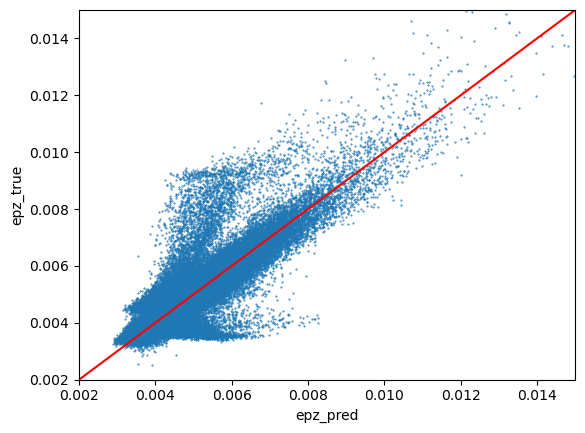

In [193]:
#plot the true vs predicted epz
fig,ax = plt.subplots()
plt.scatter(df['epz_pred'],df['epz'],s=0.2)     #plot of true vs predicted
plt.plot([0,1],[0,1],color = 'red')                           #plot overlayed y=x line      
ax.set_xlim(0.002,0.015)
ax.set_ylim(0.002,0.015)
plt.ylabel('epz_true')
plt.xlabel('epz_pred')

Here it appears that the main branch of this distribution follow the line y = x. However there are two branches that fork off from this straight y=x line. Overall the model is not bad because the majority of points follow the y=x curve.

Text(0.5, 0, 'pz')

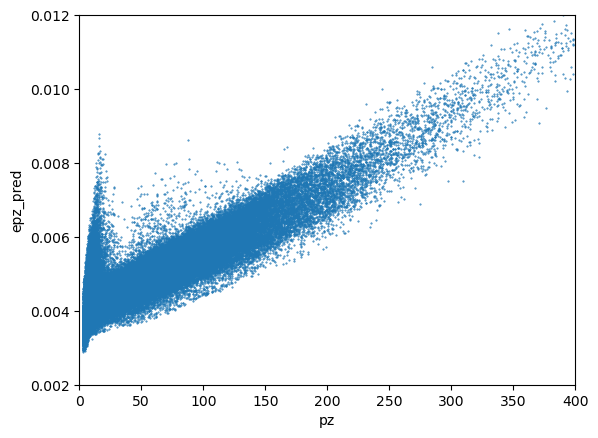

In [195]:
#reproduce figure 1 with predicted epz
fig,ax = plt.subplots()
plt.scatter(df['pz'],df['epz_pred'],s=0.2)
ax.set_xlim(0,400)
ax.set_ylim(0.002,0.012)
plt.ylabel('epz_pred')
plt.xlabel('pz')

The general shape follows the shape of the graph in figure 1. Notice the first (left-most) branch is almost vertical below pz = 50 GeV/c  which resembles the first branch in fig 1. There is a second linear branch that has similar gradient to a corresponding branch in figure one, however in figure 1 this corresponding branch splits off into two branches whereas with the predicted data, it remains as a single branch.